# Tensor Flow Text Classification using RNN

This code started off as the tutorial from Tensor Flow
https://www.tensorflow.org/text/tutorials/text_classification_rnn

I have made modifications to allow my datasets, ability to switch between datasets and optimizers,
created my own code for splitting the datasets into training, validation and testing, batched the datasets,
changed the NN models, added features for regularization of NN layers, etc. 

In [26]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import numpy as np

In [27]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Choosing the Dataset

1. Set `tickerSymbol` to a stock ticker from the list below. 
2. Set `textChoice` to 'title' or 'content'. Chooses whether to use the just the 'title' or entire 'content' from the news article. 

The datasets were created by filtering out a selected stock from this news archive dataset: 
[Kaggle - US Equities News Data](https://www.kaggle.com/datasets/gennadiyr/us-equities-news-data?resource=download)

Then the historical price dataset for the stock was downloaded from: 
[Nasdaq - Historical Data](https://www.nasdaq.com/market-activity/quotes/historical)

The 2 datasets were merged and cleaned up to contain only what was needed. The datasets contain the 
date (which was used for merging), the news article title or content, and a label indicating that the daily
price increased (1) (or statyed the same) or decreased (0). 

In [28]:
# Choose a stock
# 'AAPL' 'MSFT' 'AMZN' 'TSLA' 'NFLX' 'GOOGL' 'BA'  
tickerSymbol = 'AAPL'
textChoice = 'title' # 'title' 'content'

dataFile = '../Data/' + tickerSymbol + '_' + textChoice + '_' + 'NewsDataset.csv'

Change the `SHUFFLE_SEED` to re-shuffle the dataset prior to running. 

The seed allows reproducibility to repeat a run.

In [29]:
# Change this seed for a different shuffle. 
# Seed is here to create reproducible results, if needed. 
SHUFFLE_SEED = 12345

stockDF = pd.read_csv(dataFile)
stockDF = stockDF.sample(frac=1, random_state=SHUFFLE_SEED)

`BATCH_SIZE`, `TRAIN_PERCENT`, and `VALID_PERCENT` can be adjusted here.

1. `BATCH_SIZE` is the number of text features per batch
2. `TRAIN_PERCENT` is the percent of the dataset that is used for training vs. testing.
3. `VALID_PERCENT` is the percent of the training dataset that is used for validation.

In [30]:
N = len(stockDF)
BATCH_SIZE = 32
TRAIN_PERCENT = 0.8
VALID_PERCENT = 0.2

trainSize = int(N * TRAIN_PERCENT)
validSize = int(trainSize * VALID_PERCENT)

train_df = stockDF.iloc[:trainSize-validSize]
valid_df = stockDF.iloc[trainSize-validSize:trainSize]
test_df  = stockDF.iloc[trainSize: N]

In [31]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['Text'],train_df['Label']))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['Text'],valid_df['Label']))
test_ds  = tf.data.Dataset.from_tensor_slices((test_df['Text'],test_df['Label']))

train_ds = train_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds  = test_ds.batch(BATCH_SIZE)

## Tokenization

Tokenization is performed using Keras built in tokenizer. In the cell below, parameters can be adjusted to affect tokenization.

1. `VOCAB_SIZE` is the max vocab size created from the dataset
2. `NGRAMS` allows ngrams to be used for tokenization. If a tuple is used, multiple ngrams are used. 
3. `TOKENIZATION_TYPE` allows for a standard index or batched index to be used. 

See [TF API Keras Vectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

In [32]:
VOCAB_SIZE          = 1000
NGRAMS              = None      # None, 1, 2, etc. (1,2,3)
TOKENIZATION_TYPE   = 'int'     # 'int', 'multi_hot', 'count', 'tf_idf'

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, ngrams=NGRAMS, output_mode=TOKENIZATION_TYPE)
encoder.adapt(train_ds.map(lambda Text, Label: Text))

In [33]:
# First 20 words of vocab created from data
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'apple', 'earnings', 'stock', 'stocks', 'market',
       'tech', 'new', 'china', 'buy', 'top', 'iphone', 'trade', '5',
       'estimates', 'zacks', 'amazon', 'q1', 'growth'], dtype='<U15')

## NN Model

Below is the model definition. 

1. `L2_REGULARIZATION` can be adjusted to reduce the weights of the model to make a more generic model and avoid over fitting. 

In [34]:
L2_REGULARIZATION = 0.01    # Default = 0.01

In [35]:
# model = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(
#         input_dim=len(encoder.get_vocabulary()),
#         output_dim=64,
#         mask_zero=True),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))),
#     tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION)),
#     tf.keras.layers.Dense(1)
# ])

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

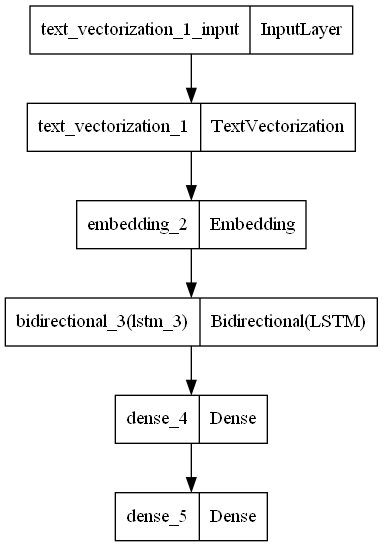

In [36]:
tf.keras.utils.plot_model(model)

## Training

1. `EPOCHS` is the iteration of entire dataset ran during training.
2. `VALIDATION_STEPS` Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
    1. See [TF Keras Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit)
3. `LOSS_CLASS` sets the type of loss function used
4. `LEARNING_RATE` sets the learning rate of the optimizer. 0.03, 0.01, 0.003, 0.001, etc.


In [14]:
EPOCHS              = 12
VALIDATION_STEPS    = None              # None 20, 40, etc. None will use all validation data
LOSS_CLASS          = 'CrossEntropy'    # 'CrossEntropy' 'FocalCrossEntropy' 
LEARNING_RATE       = 1e-4              # Learning rate for optimizer

In [ ]:
loss = {
    'CrossEntropy'      : tf.keras.losses.BinaryCrossentropy(from_logits=True),
    'FocalCrossEntropy' : tf.keras.losses.BinaryFocalCrossentropy(from_logits=True)
}

optimizer=tf.keras.optimizers.Adam(LEARNING_RATE)

metrics =   [   
                tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'), 
                tf.keras.metrics.BinaryAccuracy(from_logits=True, name='binary_accuracy'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]

In [15]:
model.compile(loss=loss[LOSS_CLASS],
              optimizer=optimizer,
              metrics=metrics)

In [16]:
# Model training
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=test_ds,
                    validation_steps=VALIDATION_STEPS)

Epoch 1/12
350/350 [==============================] - 6s 7ms/step - loss: 21.2001 - binary_crossentropy: 0.6904 - accuracy: 0.4536 - val_loss: 14.4886 - val_binary_crossentropy: 0.6834 - val_accuracy: 0.4094
Epoch 2/12
350/350 [==============================] - 1s 4ms/step - loss: 10.2940 - binary_crossentropy: 0.6887 - accuracy: 0.4536 - val_loss: 6.9412 - val_binary_crossentropy: 0.6819 - val_accuracy: 0.4094
Epoch 3/12
350/350 [==============================] - 1s 4ms/step - loss: 4.9102 - binary_crossentropy: 0.6887 - accuracy: 0.4536 - val_loss: 3.3122 - val_binary_crossentropy: 0.6817 - val_accuracy: 0.4094
Epoch 4/12
350/350 [==============================] - 1s 4ms/step - loss: 2.3964 - binary_crossentropy: 0.6888 - accuracy: 0.4536 - val_loss: 1.6889 - val_binary_crossentropy: 0.6817 - val_accuracy: 0.4094
Epoch 5/12
350/350 [==============================] - 1s 4ms/step - loss: 1.3149 - binary_crossentropy: 0.6888 - accuracy: 0.4536 - val_loss: 1.0282 - val_binary_crossentrop

## Results

Testing the test dataset.

In [17]:
test_loss, test_bin, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Binary Cross Entropy:', test_bin)
print('Test Accuracy:', test_acc)

110/110 [==============================] - 0s 2ms/step - loss: 0.6897 - binary_crossentropy: 0.6897 - accuracy: 0.4583
Test Loss: 0.689744234085083
Test Binary Cross Entropy: 0.6897246837615967
Test Accuracy: 0.4582618772983551


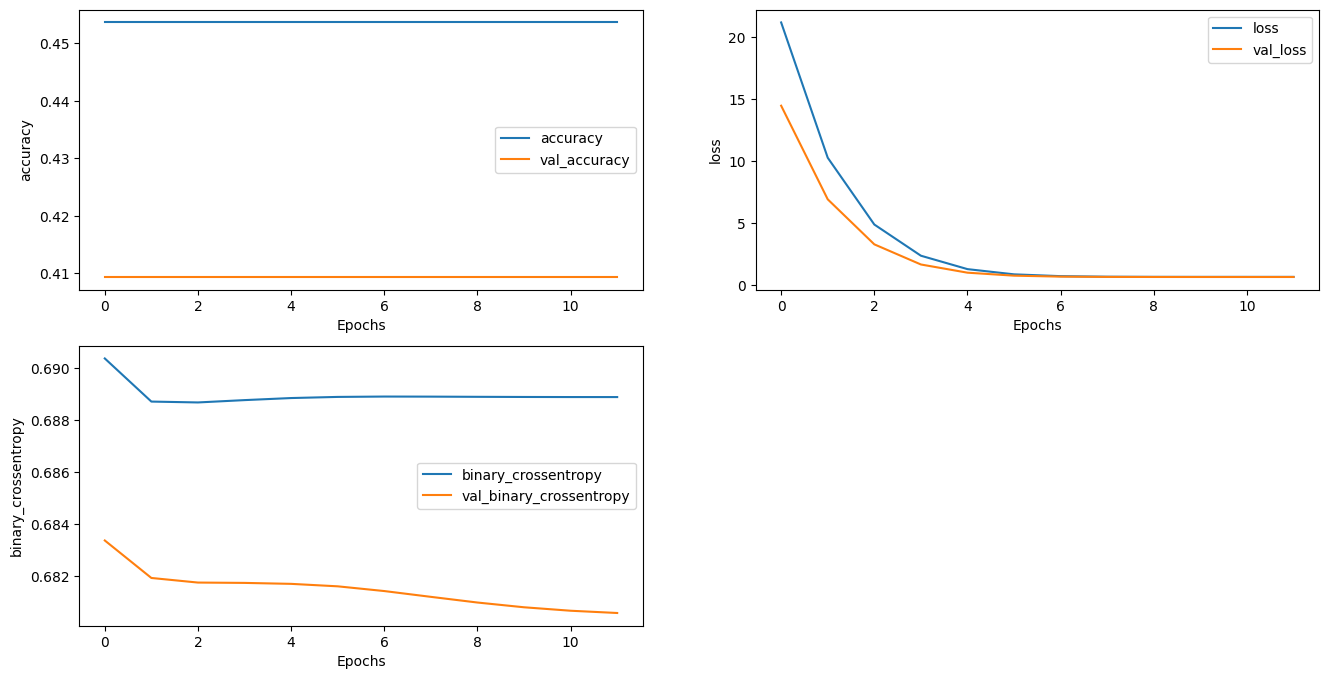

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plot_graphs(history, 'accuracy')
#plt.ylim(None, 1)
plt.subplot(2, 2, 2)
plot_graphs(history, 'loss')
#plt.ylim(0, None)
plt.subplot(2, 2, 3)
plot_graphs(history, 'binary_crossentropy')
#plt.ylim(0, None)

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

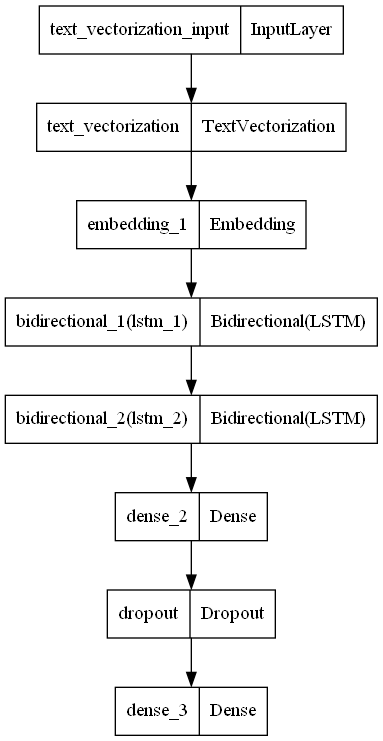

In [20]:
tf.keras.utils.plot_model(model)

In [21]:
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [22]:
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=test_ds,
                    validation_steps=VALIDATION_STEPS)

Epoch 1/12
350/350 [==============================] - 11s 13ms/step - loss: 17.0745 - binary_crossentropy: 0.6898 - accuracy: 0.4536 - val_loss: 5.5847 - val_binary_crossentropy: 0.6833 - val_accuracy: 0.4094
Epoch 2/12
350/350 [==============================] - 3s 7ms/step - loss: 3.1432 - binary_crossentropy: 0.6891 - accuracy: 0.4536 - val_loss: 1.7163 - val_binary_crossentropy: 0.6827 - val_accuracy: 0.4094
Epoch 3/12
350/350 [==============================] - 3s 7ms/step - loss: 1.2352 - binary_crossentropy: 0.6891 - accuracy: 0.4536 - val_loss: 0.9280 - val_binary_crossentropy: 0.6822 - val_accuracy: 0.4094
Epoch 4/12
350/350 [==============================] - 2s 7ms/step - loss: 0.8228 - binary_crossentropy: 0.6890 - accuracy: 0.4536 - val_loss: 0.7448 - val_binary_crossentropy: 0.6821 - val_accuracy: 0.4094
Epoch 5/12
350/350 [==============================] - 2s 7ms/step - loss: 0.7238 - binary_crossentropy: 0.6893 - accuracy: 0.4536 - val_loss: 0.6982 - val_binary_crossentrop

In [23]:
test_loss, test_bin, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Binary Cross Entropy:', test_bin)
print('Test Accuracy:', test_acc)

110/110 [==============================] - 0s 2ms/step - loss: 0.6897 - binary_crossentropy: 0.6897 - accuracy: 0.4583
Test Loss: 0.6897039413452148
Test Binary Cross Entropy: 0.6896932125091553
Test Accuracy: 0.4582618772983551


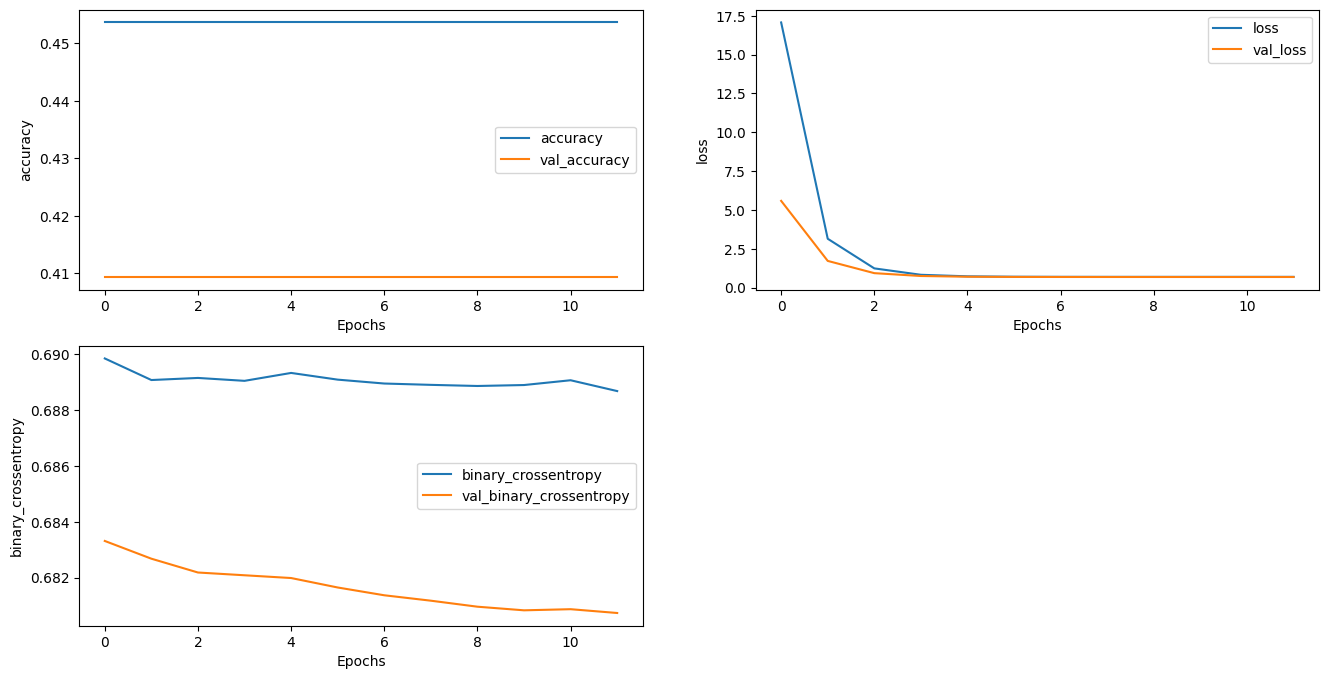

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plot_graphs(history, 'accuracy')
#plt.ylim(None, 1)
plt.subplot(2, 2, 2)
plot_graphs(history, 'loss')
#plt.ylim(0, None)
plt.subplot(2, 2, 3)
plot_graphs(history, 'binary_crossentropy')
#plt.ylim(0, None)